# Multi-channel Deconvolution

In [15]:
import torch
import sys
sys.path.insert(0, '/Users/utsavakhaury/Thesis/Multichannel_Deconv/')
from DPIR.models.network_unet import UNetRes as net
from skimage.restoration import estimate_sigma

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from MBDeconv_FISTA import *
from astropy.io import fits
from skimage.transform import resize
from matplotlib.colors import SymLogNorm

In [111]:
# Resize image while conserving flux
def resize_conserve_flux(img, size):
        orig_size = img.shape[0]
        img = resize(img, size, anti_aliasing=True)
        return img / (size[0]/orig_size)**2

In [112]:
psf_r = resize_conserve_flux(fits.open('../Data/psf_CFHT_r_2.fits')[0].data, (128,128))
psf_i = resize_conserve_flux(fits.open('../Data/psf_CFHT_i_2.fits')[0].data, (128,128))
psf_z = resize_conserve_flux(fits.open('../Data/psf_CFHT_z_2.fits')[0].data, (128,128))

psf_r /= np.sum(psf_r)
psf_i /= np.sum(psf_i)
psf_z /= np.sum(psf_z)

psf_lsst = np.stack([psf_r, psf_i, psf_z], axis=-1)

psf_euc = fits.open('../Data/psf_Euclid_VIS.fits')[0].data
psf_euc /= np.sum(psf_euc)

psf_r.shape, psf_i.shape, psf_z.shape, psf_lsst.shape, psf_euc.shape

((128, 128), (128, 128), (128, 128), (128, 128, 3), (128, 128))

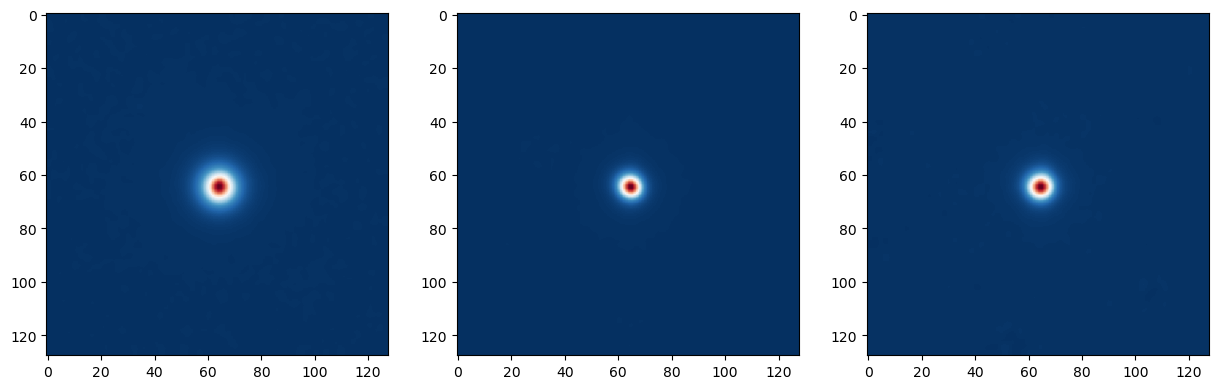

In [131]:
plt.subplots(1,3, figsize=(15,5))
plt.subplot(131)
plt.imshow(psf_r, cmap='RdBu_r')
plt.subplot(132)
plt.imshow(psf_i, cmap='RdBu_r')
plt.subplot(133)
plt.imshow(psf_z, cmap='RdBu_r')
plt.show()

### Load Data

In [345]:
noisy = np.load('../Data/cfht.npy')           # Noisy LSST images in the 3 bands (32 X 32 in this case)
euclid = np.load('../Data/euc.npy')              # Euclid image in the VIS band (64 X 64 in this case)

# noisemap = [(np.std(noisy[:10,:10,0]) + np.std(noisy[:10,-10:,0]) + np.std(noisy[-10:,:10,0]) + np.std(noisy[-10:,-10:,0]))/16,
#             (np.std(noisy[:10,:10,1]) + np.std(noisy[:10,-10:,1]) + np.std(noisy[-10:,:10,1]) + np.std(noisy[-10:,-10:,1]))/16,
#             (np.std(noisy[:10,:10,2]) + np.std(noisy[:10,-10:,2]) + np.std(noisy[-10:,:10,2]) + np.std(noisy[-10:,-10:,2]))/16,
#             (np.std(euclid[:20,:20]) + np.std(euclid[:20,-20:]) + np.std(euclid[-20:,:20]) + np.std(euclid[-20:,-20:]))/16]    

noisemap = [1,1,1,1]       

sed = np.array([0.3785673920923963, 0.34680928104045883, 0.2746233268671448])     # Fractional contribution of the 3 bands to the Euclid image

In [346]:
noisy.shape

(64, 64, 3)

In [347]:
# noisy[...,0] = np.full_like(noisy[...,0], 0.01)
# noisy[...,0] = np.random.normal(0, 1, noisy[...,0].shape)
# noisy[...,1] = np.random.normal(0, 1, noisy[...,1].shape)
# noisy[...,2] = np.random.normal(0, 1, noisy[...,2].shape)

### Run Deconvolution

In [348]:
mbdeconv = runDeconv(noisy, 
                     euclid, 
                     psf_lsst, 
                     psf_euc, 
                     noisemap, 
                     n_iter=200,              # Number of iterations (200 is sufficient for convergence)
                     SED=sed, 
                     frac_contr=0.3)          # Fractional contribution of the constraining term in the loss function found using grid search. No need to change this value

In [349]:
mbdeconv.shape

(128, 128, 3)

In [350]:
hdu = fits.PrimaryHDU(euclid)
hdu.writeto('../Data/euclid_vis.fits', overwrite=True)

hdu = fits.PrimaryHDU(noisy[...,0])
hdu.writeto('../Data/cfht_r.fits', overwrite=True)

hdu = fits.PrimaryHDU(noisy[...,1])
hdu.writeto('../Data/cfht_i.fits', overwrite=True)

hdu = fits.PrimaryHDU(noisy[...,2])
hdu.writeto('../Data/cfht_z.fits', overwrite=True)

hdu = fits.PrimaryHDU(mbdeconv[...,0])
hdu.writeto('../Data/deconvolution_r.fits', overwrite=True)

hdu = fits.PrimaryHDU(mbdeconv[...,1])
hdu.writeto('../Data/deconvolution_i.fits', overwrite=True)

hdu = fits.PrimaryHDU(mbdeconv[...,2])
hdu.writeto('../Data/deconvolution_z.fits', overwrite=True)

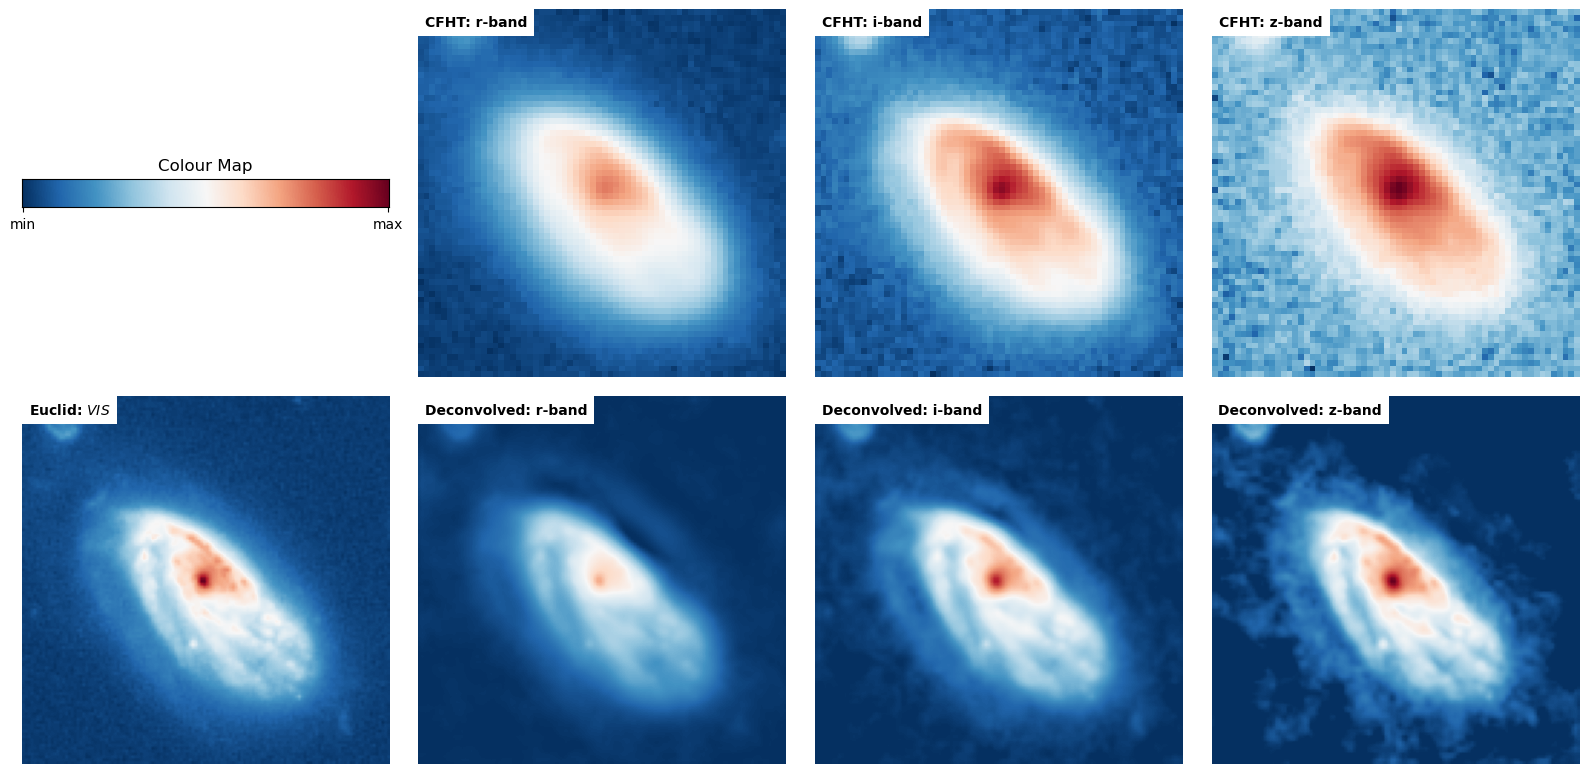

In [450]:
# now open the fits files and plot all next to each other
euclid = fits.open('../Data/euclid_vis.fits')[0].data
cfht_r = fits.open('../Data/cfht_r.fits')[0].data
cfht_i = fits.open('../Data/cfht_i.fits')[0].data
cfht_z = fits.open('../Data/cfht_z.fits')[0].data

deconv_r = fits.open('../Data/deconvolution_r.fits')[0].data
deconv_i = fits.open('../Data/deconvolution_i.fits')[0].data
deconv_z = fits.open('../Data/deconvolution_z.fits')[0].data

cmap = 'RdBu_r'
fig, axs = plt.subplots(2, 4, figsize=(16,8))
for i,j in np.ndindex(axs.shape):
    if i!=0 or j!=0:
        axs[i,j].axis('off')
        
def scale(arr):
    # return arr
    return np.log10(arr - np.min(arr) + 10)
       
axs[1,0].imshow(scale(euclid), cmap=cmap, origin='lower')
axs[1,0].text(.02, .9425, 'Euclid: $VIS$', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,0].transAxes)

vmax_cfht = np.max([np.max(scale(cfht_r)), np.max(scale(cfht_i)), np.max(scale(cfht_z))])
vmin_cfht = np.min([np.min(scale(cfht_r)), np.min(scale(cfht_i)), np.min(scale(cfht_z))])

axs[0,1].imshow(scale(cfht_r), cmap=cmap, origin='lower', vmin=vmin_cfht, vmax=vmax_cfht)
axs[0,1].text(.0175, .945, 'CFHT: r-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,1].transAxes)

axs[0,2].imshow(scale(cfht_i), cmap=cmap, origin='lower', vmin=vmin_cfht, vmax=vmax_cfht)
axs[0,2].text(.0175, .945, 'CFHT: i-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,2].transAxes)

axs[0,3].imshow(scale(cfht_z), cmap=cmap, origin='lower', vmin=vmin_cfht, vmax=vmax_cfht)
axs[0,3].text(.02, .945, 'CFHT: z-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,3].transAxes)

vmax_deconv = np.max([np.max(scale(deconv_r)), np.max(scale(deconv_i)), np.max(scale(deconv_z))])
vmin_deconv = np.min([np.min(scale(deconv_r)), np.min(scale(deconv_i)), np.min(scale(deconv_z))])

axs[1,1].imshow(scale(deconv_r), cmap=cmap, origin='lower', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1,1].text(.0175, .945, 'Deconvolved: r-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,1].transAxes)

axs[1,2].imshow(scale(deconv_i), cmap=cmap, origin='lower', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1,2].text(.0175, .945, 'Deconvolved: i-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,2].transAxes)

axs[1,3].imshow(scale(deconv_z), cmap=cmap, origin='lower', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1,3].text(.0175, .945, 'Deconvolved: z-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,3].transAxes)

# just show colormap in ax[0,3] with no values and horizontal orientation
axs[0,0].set_title('Colour Map', fontsize=12)
axs[0,0].imshow(np.rot90(np.arange(128*10).reshape(128, 10)), cmap=cmap)
axs[0,0].set_xticks([0, 127], labels=['min', 'max'])
axs[0,0].set_yticks([])

plt.tight_layout()
plt.show()

In [352]:
n_channels = 1  
drunet_model_path = '/Users/utsavakhaury/Thesis/Multichannel_Deconv/DPIR/model_zoo/drunet_gray.pth'

drunet_model = net(in_nc=n_channels+1, out_nc=n_channels, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
drunet_model.load_state_dict(torch.load(drunet_model_path), strict=True)
drunet_model.eval()
for k, v in drunet_model.named_parameters():
    v.requires_grad = False
drunet_model = drunet_model.to('cpu')
number_parameters = sum(map(lambda x: x.numel(), drunet_model.parameters()))

number_parameters

32638656

In [353]:
deconv_noisemap = np.zeros((mbdeconv.shape))
for j in range(mbdeconv.shape[-1]):
    deconv_noisemap[...,j] = np.array(estimate_sigma(mbdeconv[...,j])).reshape(-1,1,1)
print(deconv_noisemap.shape)

(128, 128, 3)


In [354]:
res_drunet = np.zeros((mbdeconv.shape))
for ch in range(res_drunet.shape[-1]):
    res_drunet[...,ch] = drunet_model(torch.FloatTensor(np.expand_dims(np.vstack((np.expand_dims(mbdeconv[...,ch], -1).T, 
                                                                    np.expand_dims(deconv_noisemap[...,ch]*36.5, -1).T)).T, 0)).permute(0,3,1,2)).permute(0,2,3,1).detach().numpy().squeeze()
res_drunet.shape

(128, 128, 3)

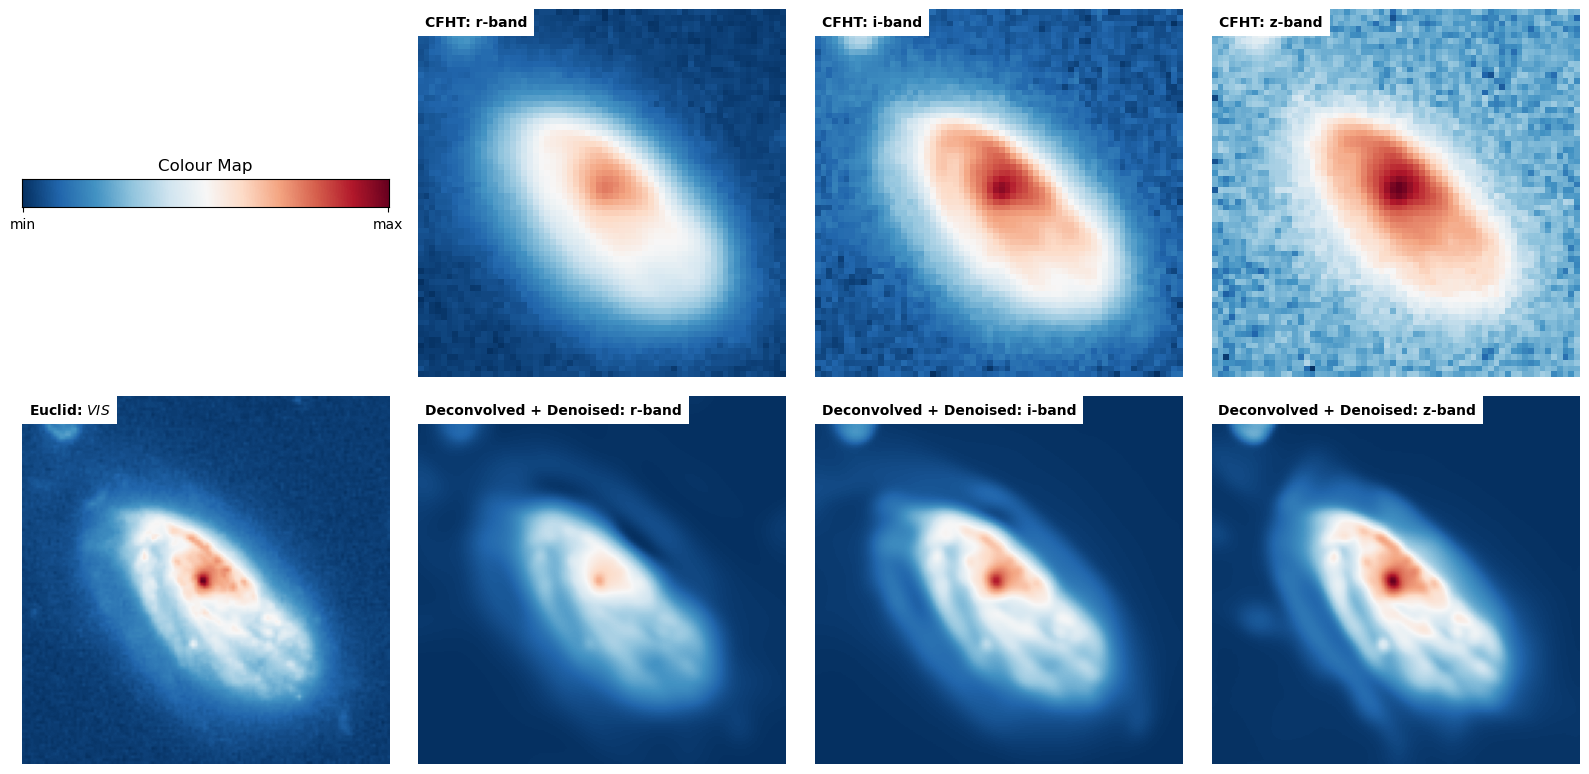

In [449]:
cmap = 'RdBu_r'
fig, axs = plt.subplots(2, 4, figsize=(16,8))
for i,j in np.ndindex(axs.shape):
    if i!=0 or j!=0:
        axs[i,j].axis('off')
        
def scale(arr):
    # return arr
    return np.log10(arr - np.min(arr) + 10)
       
axs[1,0].imshow(scale(euclid), cmap=cmap, origin='lower')
axs[1,0].text(.02, .9425, 'Euclid: $VIS$', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,0].transAxes)

vmax_cfht = np.max([np.max(scale(cfht_r)), np.max(scale(cfht_i)), np.max(scale(cfht_z))])
vmin_cfht = np.min([np.min(scale(cfht_r)), np.min(scale(cfht_i)), np.min(scale(cfht_z))])

axs[0,1].imshow(scale(cfht_r), cmap=cmap, origin='lower', vmin=vmin_cfht, vmax=vmax_cfht)
axs[0,1].text(.0175, .945, 'CFHT: r-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,1].transAxes)

axs[0,2].imshow(scale(cfht_i), cmap=cmap, origin='lower', vmin=vmin_cfht, vmax=vmax_cfht)
axs[0,2].text(.0175, .945, 'CFHT: i-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,2].transAxes)

axs[0,3].imshow(scale(cfht_z), cmap=cmap, origin='lower', vmin=vmin_cfht, vmax=vmax_cfht)
axs[0,3].text(.02, .945, 'CFHT: z-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,3].transAxes)

vmax_deconv = np.max([np.max(scale(res_drunet[...,0])), np.max(scale(res_drunet[...,1])), np.max(scale(res_drunet[...,2]))])
vmin_deconv = np.min([np.min(scale(res_drunet[...,0])), np.min(scale(res_drunet[...,1])), np.min(scale(res_drunet[...,2]))])

axs[1,1].imshow(scale(res_drunet[...,0]), cmap=cmap, origin='lower', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1,1].text(.0175, .945, 'Deconvolved + Denoised: r-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,1].transAxes)

axs[1,2].imshow(scale(res_drunet[...,1]), cmap=cmap, origin='lower', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1,2].text(.0175, .945, 'Deconvolved + Denoised: i-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,2].transAxes)

axs[1,3].imshow(scale(res_drunet[...,2]), cmap=cmap, origin='lower', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1,3].text(.0175, .945, 'Deconvolved + Denoised: z-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,3].transAxes)

# just show colormap in ax[0,3] with no values and horizontal orientation
axs[0,0].set_title('Colour Map', fontsize=12)
axs[0,0].imshow(np.rot90(np.arange(128*10).reshape(128, 10)), cmap=cmap)
axs[0,0].set_xticks([0, 127], labels=['min', 'max'])
axs[0,0].set_yticks([])

plt.tight_layout()
plt.show()

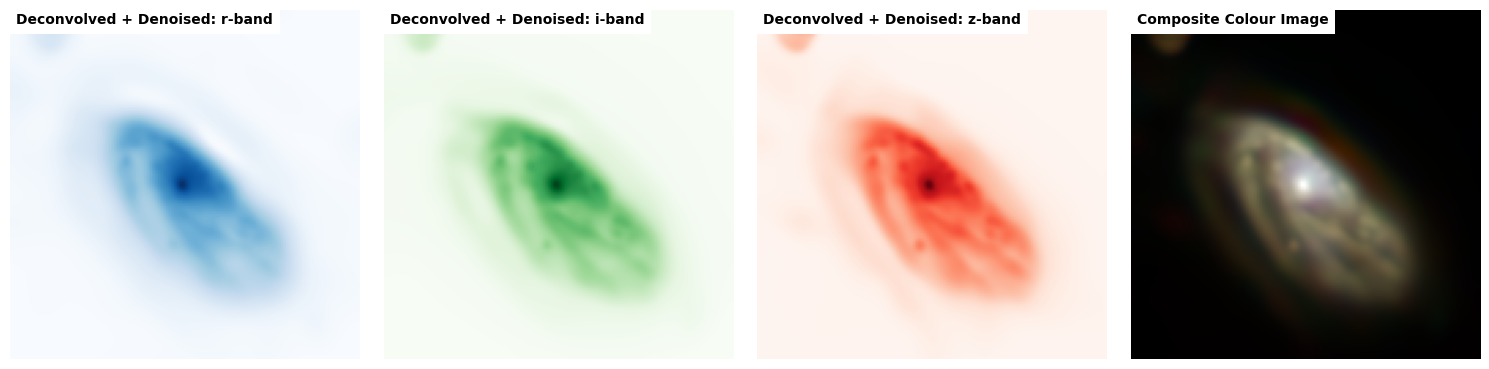

In [448]:
# write a function to normalise image within [0,1]. The dynamic range of each channel must be preserved, i.e. if one channel has a higher dynamic range, it should be scaled down to [0,1] while preserving the relative values of the pixels
def normalise(img):
    return (img - np.min(img))/(np.max(img) - np.min(img))

fig, axs = plt.subplots(1, 4, figsize=(15,6))
for i in range(4):
    axs[i].axis('off')

vmax_deconv = np.max([np.max(normalise(scale(res_drunet[...,0]))), np.max(normalise(scale(res_drunet[...,1]))), np.max(normalise(scale(res_drunet[...,2])))])
vmin_deconv = np.min([np.min(normalise(scale(res_drunet[...,0]))), np.min(normalise(scale(res_drunet[...,1]))), np.min(normalise(scale(res_drunet[...,2])))])

axs[0].imshow(normalise(scale(res_drunet[...,0])), origin='lower', cmap='Blues', vmin=vmin_deconv, vmax=vmax_deconv)
axs[0].text(.0175, .95, 'Deconvolved + Denoised: r-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0].transAxes)
axs[1].imshow(normalise(scale(res_drunet[...,1])), origin='lower', cmap='Greens', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1].text(.0175, .95, 'Deconvolved + Denoised: i-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1].transAxes)
axs[2].imshow(normalise(scale(res_drunet[...,2])), origin='lower', cmap='Reds', vmin=vmin_deconv, vmax=vmax_deconv)
axs[2].text(.0175, .95, 'Deconvolved + Denoised: z-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[2].transAxes)

max1 = np.max(res_drunet[...,2])
max2 = np.max(res_drunet[...,1])
max3 = np.max(res_drunet[...,0])
max_val = np.max([max1, max2, max3])

axs[3].imshow(np.stack([normalise(scale(res_drunet[...,2]*(max1/max_val))), 
                        normalise(scale(res_drunet[...,1]*(max2/max_val))), 
                        normalise(scale(res_drunet[...,0]*(max3/max_val)))], axis=-1), origin='lower')
axs[3].text(.0165, .95, 'Composite Colour Image', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[3].transAxes)
plt.tight_layout()

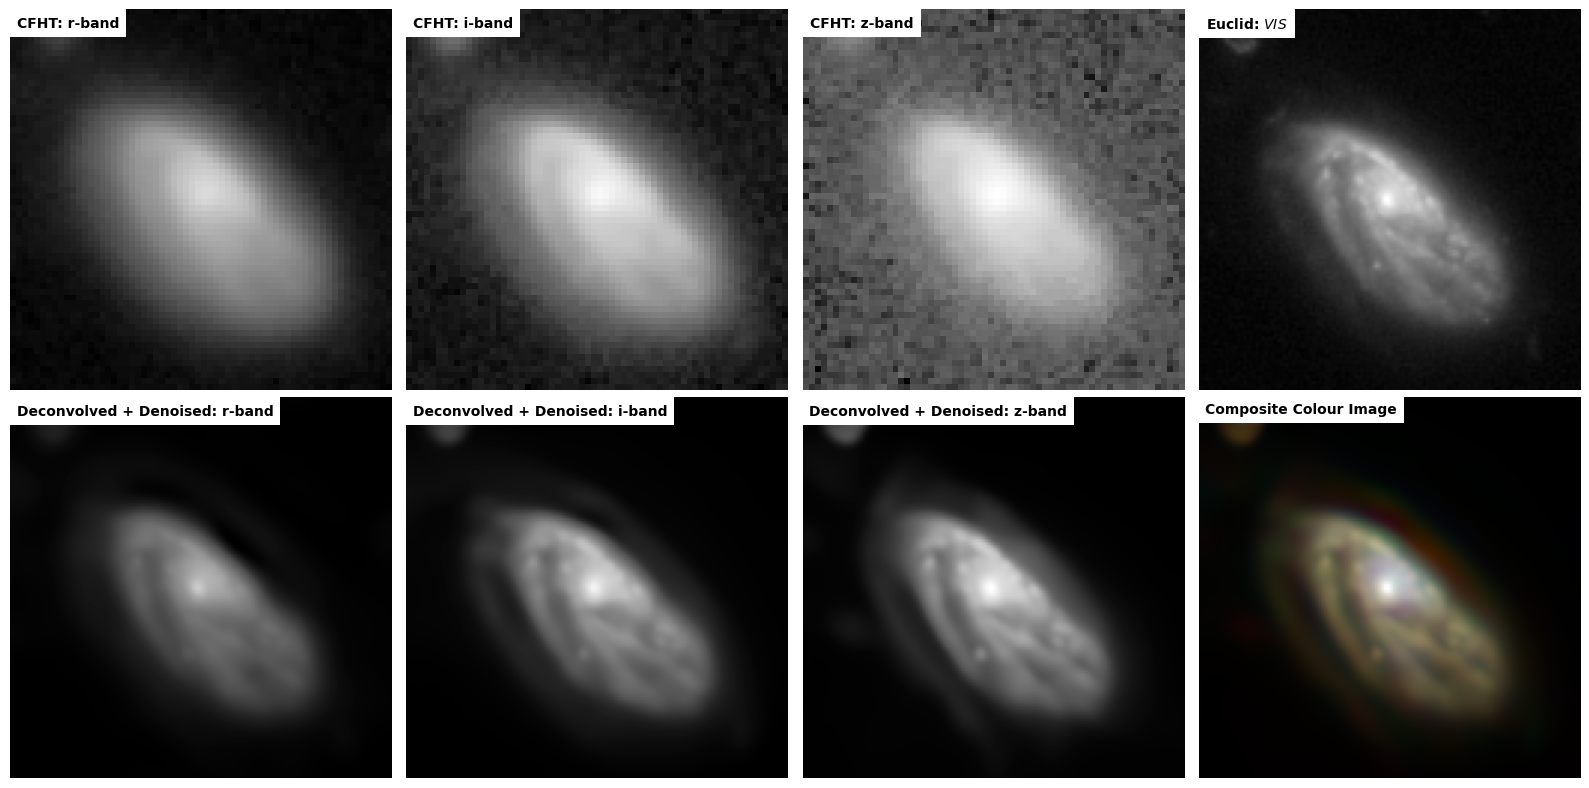

In [451]:
cmap = 'Greys_r'
fig, axs = plt.subplots(2, 4, figsize=(16,8))

for i,j in np.ndindex(axs.shape):
    axs[i,j].axis('off')

axs[0,3].imshow(scale(euclid), cmap=cmap, origin='lower')
axs[0,3].text(.02, .9425, 'Euclid: $VIS$', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,3].transAxes)

vmax_cfht = np.max([np.max(scale(cfht_r)), np.max(scale(cfht_i)), np.max(scale(cfht_z))])
vmin_cfht = np.min([np.min(scale(cfht_r)), np.min(scale(cfht_i)), np.min(scale(cfht_z))])

axs[0,0].imshow(scale(cfht_r), cmap=cmap, origin='lower', vmin=vmin_cfht, vmax=vmax_cfht)
axs[0,0].text(.0175, .945, 'CFHT: r-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,0].transAxes)

axs[0,1].imshow(scale(cfht_i), cmap=cmap, origin='lower', vmin=vmin_cfht, vmax=vmax_cfht)
axs[0,1].text(.0175, .945, 'CFHT: i-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,1].transAxes)

axs[0,2].imshow(scale(cfht_z), cmap=cmap, origin='lower', vmin=vmin_cfht, vmax=vmax_cfht)
axs[0,2].text(.02, .945, 'CFHT: z-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,2].transAxes)

vmax_deconv = np.max([np.max(scale(res_drunet[...,0])), np.max(scale(res_drunet[...,1])), np.max(scale(res_drunet[...,2]))])
vmin_deconv = np.min([np.min(scale(res_drunet[...,0])), np.min(scale(res_drunet[...,1])), np.min(scale(res_drunet[...,2]))])

axs[1,0].imshow(scale(res_drunet[...,0]), cmap=cmap, origin='lower', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1,0].text(.0175, .945, 'Deconvolved + Denoised: r-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,0].transAxes)

axs[1,1].imshow(scale(res_drunet[...,1]), cmap=cmap, origin='lower', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1,1].text(.0175, .945, 'Deconvolved + Denoised: i-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,1].transAxes)

axs[1,2].imshow(scale(res_drunet[...,2]), cmap=cmap, origin='lower', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1,2].text(.0175, .945, 'Deconvolved + Denoised: z-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,2].transAxes)

max1 = np.max(res_drunet[...,2])
max2 = np.max(res_drunet[...,1])
max3 = np.max(res_drunet[...,0])
max_val = np.max([max1, max2, max3])

axs[1,3].imshow(np.stack([normalise(scale(res_drunet[...,2]*(max1/max_val))), 
                        normalise(scale(res_drunet[...,1]*(max2/max_val))), 
                        normalise(scale(res_drunet[...,0]*(max3/max_val)))], axis=-1), origin='lower')
axs[1,3].text(.0165, .95, 'Composite Colour Image', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,3].transAxes)

plt.tight_layout()
plt.show()

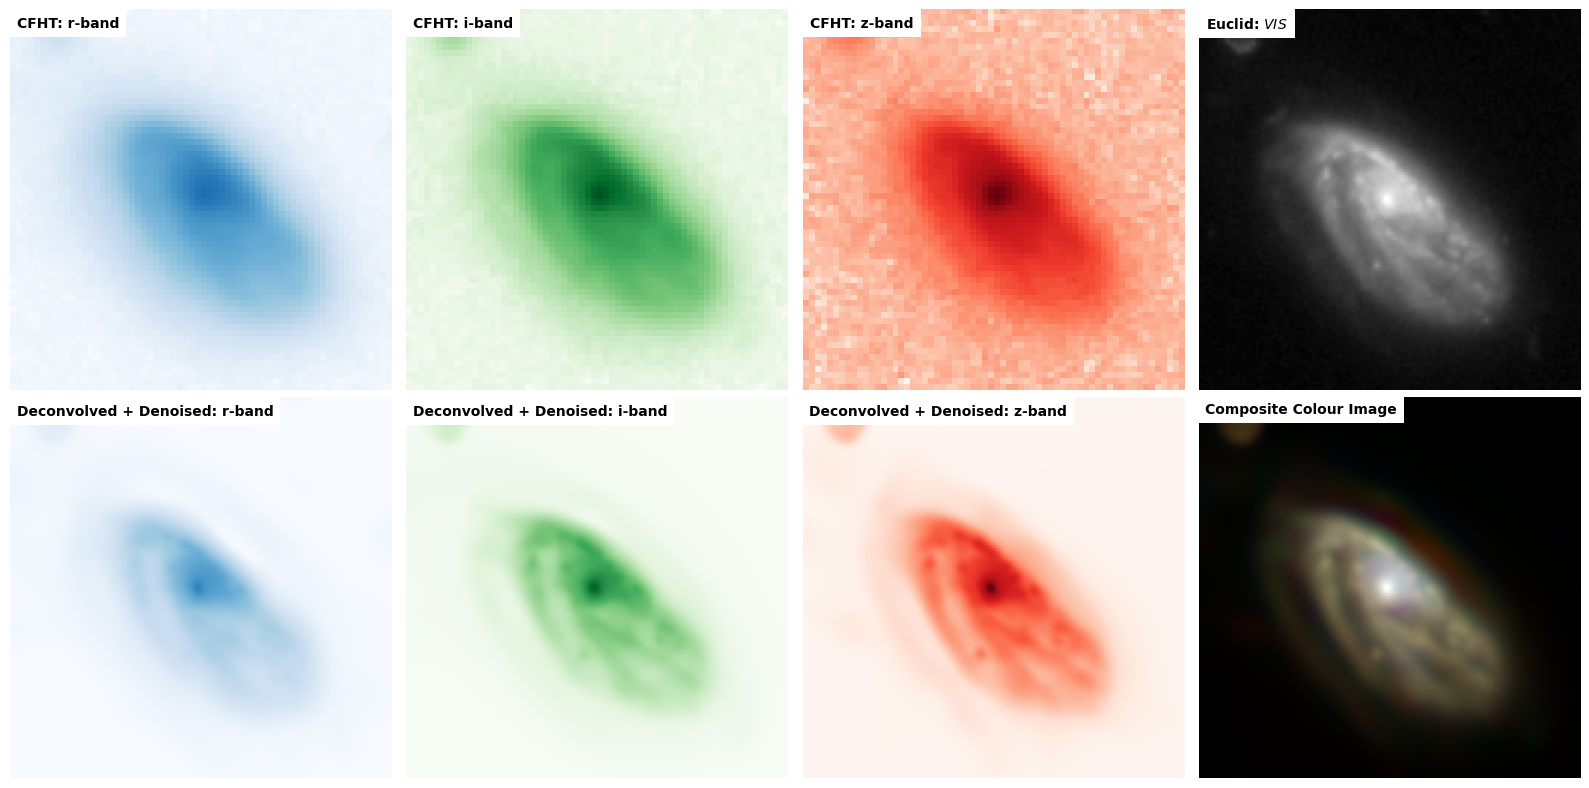

In [452]:
cmap = 'RdBu_r'
fig, axs = plt.subplots(2, 4, figsize=(16,8))

for i,j in np.ndindex(axs.shape):
    axs[i,j].axis('off')

axs[0,3].imshow(scale(euclid), cmap='Greys_r', origin='lower')
axs[0,3].text(.02, .9425, 'Euclid: $VIS$', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,3].transAxes)

vmax_cfht = np.max([np.max(scale(cfht_r)), np.max(scale(cfht_i)), np.max(scale(cfht_z))])
vmin_cfht = np.min([np.min(scale(cfht_r)), np.min(scale(cfht_i)), np.min(scale(cfht_z))])

axs[0,0].imshow(scale(cfht_r), cmap='Blues', origin='lower', vmin=vmin_cfht, vmax=vmax_cfht)
axs[0,0].text(.0175, .945, 'CFHT: r-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,0].transAxes)

axs[0,1].imshow(scale(cfht_i), cmap='Greens', origin='lower', vmin=vmin_cfht, vmax=vmax_cfht)
axs[0,1].text(.0175, .945, 'CFHT: i-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,1].transAxes)

axs[0,2].imshow(scale(cfht_z), cmap='Reds', origin='lower', vmin=vmin_cfht, vmax=vmax_cfht)
axs[0,2].text(.02, .945, 'CFHT: z-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[0,2].transAxes)

vmax_deconv = np.max([np.max(scale(res_drunet[...,0])), np.max(scale(res_drunet[...,1])), np.max(scale(res_drunet[...,2])), np.max(scale(euclid))])
vmin_deconv = np.min([np.min(scale(res_drunet[...,0])), np.min(scale(res_drunet[...,1])), np.min(scale(res_drunet[...,2])), np.min(scale(euclid))])

axs[1,0].imshow(scale(res_drunet[...,0]), cmap='Blues', origin='lower', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1,0].text(.0175, .945, 'Deconvolved + Denoised: r-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,0].transAxes)

axs[1,1].imshow(scale(res_drunet[...,1]), cmap='Greens', origin='lower', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1,1].text(.0175, .945, 'Deconvolved + Denoised: i-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,1].transAxes)

axs[1,2].imshow(scale(res_drunet[...,2]), cmap='Reds', origin='lower', vmin=vmin_deconv, vmax=vmax_deconv)
axs[1,2].text(.0175, .945, 'Deconvolved + Denoised: z-band', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,2].transAxes)

max1 = np.max(res_drunet[...,2])
max2 = np.max(res_drunet[...,1])
max3 = np.max(res_drunet[...,0])
max_val = np.max([max1, max2, max3])

axs[1,3].imshow(np.stack([normalise(scale(res_drunet[...,2]*(max1/max_val))), 
                        normalise(scale(res_drunet[...,1]*(max2/max_val))), 
                        normalise(scale(res_drunet[...,0]*(max3/max_val)))], axis=-1), origin='lower')
axs[1,3].text(.0165, .95, 'Composite Colour Image', ha='left', va='bottom', fontsize=10, fontweight="bold", color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'none'}, transform=axs[1,3].transAxes)

plt.tight_layout()
plt.show()